In [1]:
import pickle
import glob
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 입력을 적절한 형태로 변경
        x = x.view(x.size(0), x.size(1), -1)

        # LSTM 레이어
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))

        # fully connected 레이어
        out = self.fc(out[:, -1, :])

        return out.view(-1, 16, 9)

In [3]:
class BeeAnomalyDetector:
    def __init__(self, model, criterion, optimizer, device):
        # 모델, 소실 함수, 최적화 알고리즘, device 초기화
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = [] # train loss 기록
        self.val_losses = [] # val loss 기록


    def prepare_data(self, datas, sequence_length, test_size, batch_size):
        # 마지막 144개는 16:9 형태로 이루어져 있음
        # 각 그리드에는 10초 평균 객체 개수가 들어가 있음
        # sequence_length: 예측 길이
        time_series_data = []
        for frame_datas in datas:
            for frame_data in frame_datas:
                reshaped_data = frame_data[-144:].view(16, 9) # 데이터의 마지막 144개를 가져와 형태를 변경
                time_series_data.append(reshaped_data)

        time_series_data_tensor = torch.stack(time_series_data)


        X = []
        y = []
        for i in range(len(time_series_data_tensor) - sequence_length):
            X.append(time_series_data_tensor[i:i+sequence_length])
            y.append(time_series_data_tensor[i+sequence_length])

        X = torch.stack(X)
        y = torch.stack(y)

        # 데이터를 훈련 세트와 검증 세트로 분할
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

        # 데이터 로더 생성
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader

    def prepare_real_data(self, raw_data, sequence_length, batch_size):
        # 실제 예측에 사용할 데이터
        time_series_data = []
        targets = []
        for frame_datas in raw_data:
            for i in range(len(frame_datas) - sequence_length):
                reshaped_data = [frame_datas[j][-144:].view(16, 9) for j in range(i, i + sequence_length)]
                target_data = frame_datas[i + sequence_length][-144:].view(16, 9)
                time_series_data.append(torch.stack(reshaped_data))
                targets.append(target_data)

        X = torch.stack(time_series_data)
        y = torch.stack(targets)

        real_dataset = TensorDataset(X, y)
        real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)

        return real_loader


    def train_one_epoch(self, loader):
        self.model.train()
        total_loss = 0.0

        for inputs, targets in loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            self.optimizer.zero_grad() # 기울기 0 초기화
            outputs = self.model(inputs) # 예측 수행
            loss = self.criterion(outputs, targets) # loss 계산
            loss.backward() # 역전파
            self.optimizer.step() # 가중치 업데이트

            total_loss += loss.item() # 총 loss 계산

        return total_loss / len(loader)

    def validate_one_epoch(self, loader):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        return total_loss / len(loader)

    def fit(self, train_loader, val_loader, num_epochs=50, patience=5):
        # 모델 훈련 및 검증
        best_val_loss = float('inf')
        early_stopping_counter = 0

        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch(train_loader)
            val_loss = self.validate_one_epoch(val_loader)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter == patience:
                    print("Early Stopping")
                    break

    def plot_losses(self):
        # 시각화 함수
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

    def detect_anomalies(self, data_loader, threshold):
        # 이상치 탐지 함수
        anomaly_indices = []
        
        with torch.no_grad():
            self.model.eval()
            for idx, (inputs, targets) in enumerate(data_loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                error = (outputs - targets).abs().mean(dim=[1, 2]) # 각 데이터 포인트의 에러 계산, 차원별 평균 계산. 16:9 그리드의 평균을 나타냄
                                                                   # 특정 위치의 오차에 민감하지 않게 됨.
                anomalies = (error > threshold).nonzero(as_tuple=True)[0] # 임계값 보다 큰 에러 이상치로 판단

                # 이상치 인덱스 저장
                if anomalies.numel() > 0:
                    global_indices = anomalies + idx * data_loader.batch_size # 전체 데이터 세트에 대한 이상치의 인덱스 계산
                    anomaly_indices.extend(global_indices.tolist())

        return anomaly_indices


In [4]:
# 데이터 로딩
data_paths = ['./0802/']
# data_paths = ['./0809/', './0811/']
datas = []

for data_path in data_paths:
    pickle_files = glob.glob(data_path + '*.pickle')

    
    for file_path in pickle_files:
        ### 피클 파일 불러오기 ###
        with open(file_path, "rb") as fr:
            tensor_data = pickle.load(fr)
            datas.append(tensor_data)


Epoch 1/10 - Train Loss: 0.0390, Val Loss: 0.0220
Epoch 2/10 - Train Loss: 0.0208, Val Loss: 0.0187
Epoch 3/10 - Train Loss: 0.0187, Val Loss: 0.0171
Epoch 4/10 - Train Loss: 0.0172, Val Loss: 0.0162
Epoch 5/10 - Train Loss: 0.0164, Val Loss: 0.0155
Epoch 6/10 - Train Loss: 0.0158, Val Loss: 0.0150
Epoch 7/10 - Train Loss: 0.0154, Val Loss: 0.0146
Epoch 8/10 - Train Loss: 0.0150, Val Loss: 0.0142
Epoch 9/10 - Train Loss: 0.0146, Val Loss: 0.0139
Epoch 10/10 - Train Loss: 0.0144, Val Loss: 0.0138


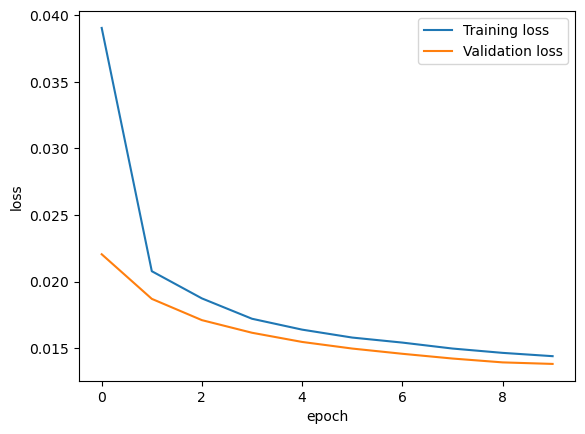

In [5]:
# 모델 하이퍼파라미터
input_size = 16*9
hidden_size = 50
num_layers = 2
output_size = 16*9

# 모델, 최적화 알고리즘, 손실 함수 생성
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# device 선택
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

# Device로 모델 이동
model.to(device)

# BeeAnomalyDetector 인스턴스 생성 및 데이터 준비
trainer = BeeAnomalyDetector(model, criterion, optimizer, device)
train_loader, val_loader = trainer.prepare_data(datas, sequence_length=6, test_size=0.3, batch_size=64)

# 훈련 및 손실 시각화
trainer.fit(train_loader, val_loader, num_epochs = 10)
trainer.plot_losses()

In [6]:
real_loader = trainer.prepare_real_data(datas,sequence_length = 6, batch_size=64)
threshold = 0.15  # 임계값 설정
anomaly_indices = trainer.detect_anomalies(real_loader, threshold)
print(f"탐지된 이상치의 인덱스: {anomaly_indices}")


탐지된 이상치의 인덱스: [1262, 1499, 1504, 1563, 4193, 5590, 6741, 6875, 6904, 9041, 9111, 9181, 10834, 10924, 11646, 11649, 11650]
